# Precipitation data analysis
## This is a notebook analyzing precipitation data from the ERA5 dataset.

In [2]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import rioxarray
import rasterio
from matplotlib.patches import Patch
from scipy.stats import linregress

In [3]:
# Load data
precipitation_data = xr.open_dataset("Data/precip-2014-2024-full.nc")

# Print the dataset structure
print(precipitation_data)

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 96432, latitude: 4, longitude: 4)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 771kB 2014-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 32B 25.12 24.88 24.62 24.38
  * longitude   (longitude) float64 32B 46.38 46.62 46.88 47.12
    expver      (valid_time) <U4 2MB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-27T13:58 GRIB to CDM+CF via cfgrib-0.9.1...


In [4]:
# Extract the total precipitation variable (tp)
precipitation = precipitation_data["tp"]

# Extract the total precipitation variable and convert to mm
precipitation_mm = precipitation_data["tp"] * 1000 

In [5]:
# Define path to the output folder relative to the notebook
output_folder = "Outputs_Precip"

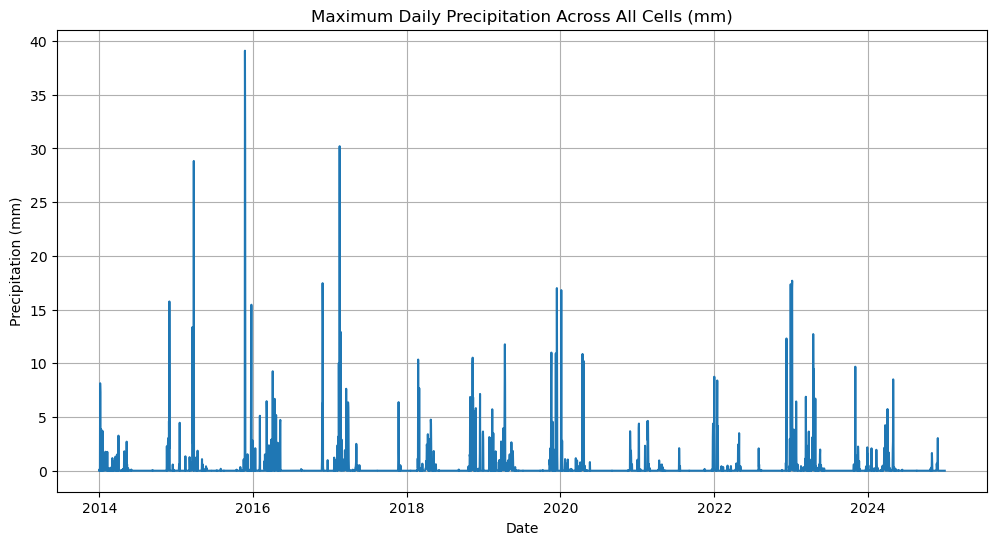

In [6]:
# Step 1: Convert to daily precipitation totals
daily_precipitation_mm = precipitation_mm.resample(valid_time="1D").sum()

# Step 2: Find the maximum precipitation across all cells for each day
max_daily_precipitation = daily_precipitation_mm.max(dim=["latitude", "longitude"])

# Step 3: Plot the maximum daily precipitation over time
plt.figure(figsize=(12, 6))
max_daily_precipitation.plot()
plt.title("Maximum Daily Precipitation Across All Cells (mm)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid()
plt.savefig(os.path.join(output_folder, "precip-4-4-max-across-all-cells.png"), dpi=300, bbox_inches="tight")
plt.show()

In [7]:
# Find the maximum daily precipitation value
max_precip_value = max_daily_precipitation.max().values

# Find the date when this maximum occurred
max_precip_date = max_daily_precipitation["valid_time"].isel(
    valid_time=max_daily_precipitation.argmax()
).values

# Print the results
print(f"Maximum daily precipitation: {max_precip_value:.2f} mm")
print(f"Date of maximum precipitation: {pd.Timestamp(max_precip_date).strftime('%Y-%m-%d')}")


Maximum daily precipitation: 39.10 mm
Date of maximum precipitation: 2015-11-24


In [8]:
# Step 1: Find the daily maximum precipitation across all grid cells
daily_max_precip = daily_precipitation_mm.max(dim=["latitude", "longitude"])

# Step 2: Convert to a pandas DataFrame for easier manipulation
daily_max_df = daily_max_precip.to_dataframe(name="Max Precipitation (mm)").reset_index()

# Step 3: Extract the year from the date and add it as a column
daily_max_df["Year"] = daily_max_df["valid_time"].dt.year

# Step 4: Identify the maximum precipitation per year
max_per_year = daily_max_df.groupby("Year")["Max Precipitation (mm)"].transform("max")

# Step 5: Filter for the rainiest day in each year
rainiest_days = daily_max_df[daily_max_df["Max Precipitation (mm)"] == max_per_year].drop_duplicates(subset=["Year"])

# Step 6: Select relevant columns and sort chronologically
rainiest_days = rainiest_days[["valid_time", "Max Precipitation (mm)", "Year"]].sort_values(by="valid_time")

# Display the result
print(rainiest_days)


     valid_time  Max Precipitation (mm)  Year
333  2014-11-30               15.756607  2014
692  2015-11-24               39.102470  2015
1061 2016-11-27               17.460037  2016
1142 2017-02-16               30.211702  2017
1774 2018-11-10               10.524147  2018
2174 2019-12-15               17.000107  2019
2195 2020-01-05               16.813387  2020
2605 2021-02-18                4.634992  2021
3285 2022-12-30               17.364189  2022
3292 2023-01-06               17.688293  2023
3772 2024-04-30                8.504062  2024


In [9]:
# Save the rainiest day per year table to a CSV file
rainiest_days.to_csv(os.path.join(output_folder, "rainiest_days_per_year.csv"), index=False)
print("Exported: rainiest_days_per_year.csv")

Exported: rainiest_days_per_year.csv


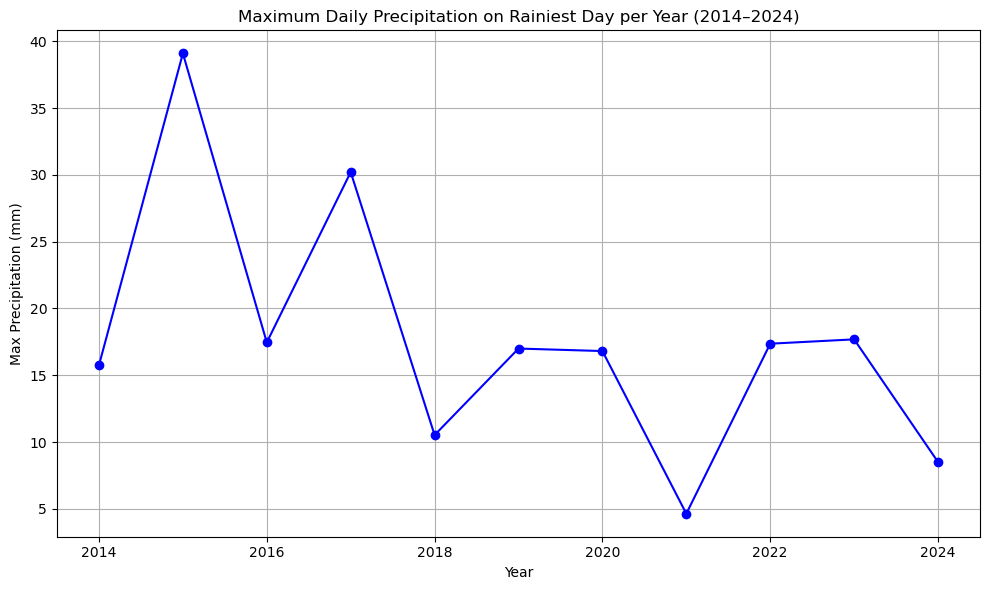

In [10]:
# Plot the rainiest day precipitation for each year
plt.figure(figsize=(10, 6))
plt.plot(rainiest_days["Year"], rainiest_days["Max Precipitation (mm)"], marker="o", color="blue")
plt.title("Maximum Daily Precipitation on Rainiest Day per Year (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Max Precipitation (mm)")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-4x4-max-per-year-top-event.png"), dpi=300, bbox_inches="tight")
plt.show()

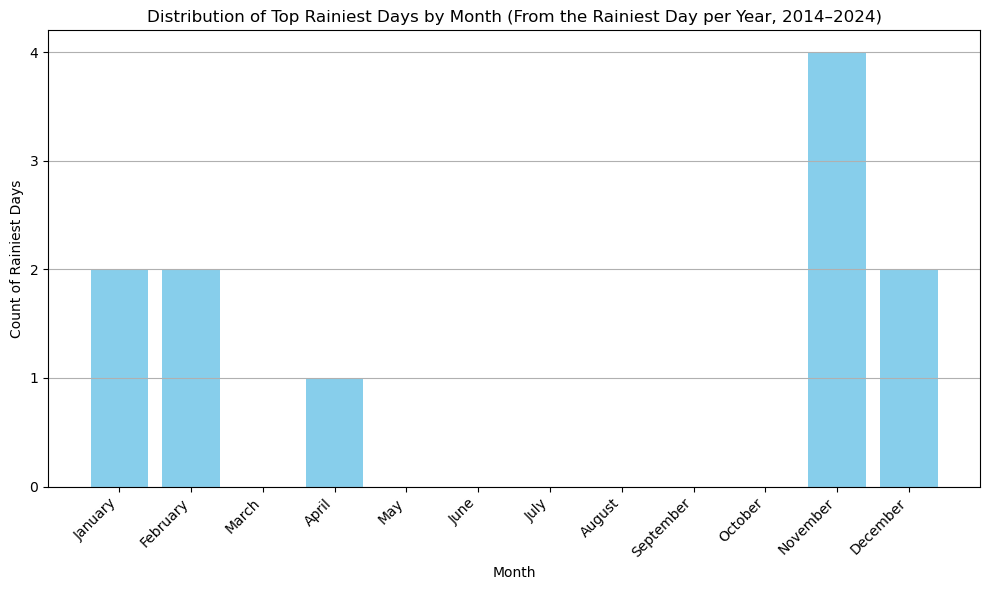

In [11]:
# Step 1: Add a column for the month
rainiest_days["Month"] = rainiest_days["valid_time"].dt.month

# Step 2: Count the rainiest days by month (across all years)
monthly_counts = rainiest_days["Month"].value_counts().sort_index()

# Step 3: Ensure all months are included (even if they have 0 counts)
all_months = list(range(1, 13))  # Months from 1 (Jan) to 12 (Dec)
monthly_counts = monthly_counts.reindex(all_months, fill_value=0)

# Step 4: Convert month numbers to names for the x-axis
month_names = [calendar.month_name[i] for i in monthly_counts.index]

# Step 5: Plot the distribution of rainiest days by month
plt.figure(figsize=(10, 6))
plt.bar(month_names, monthly_counts.values, color="skyblue")

# Fix y-axis to show only whole numbers
y_max = int(monthly_counts.max())  # Get the highest count
plt.yticks(np.arange(0, y_max + 1, 1))  # Generate ticks from 0 to y_max (inclusive)

plt.title("Distribution of Top Rainiest Days by Month (From the Rainiest Day per Year, 2014–2024)")
plt.xlabel("Month")
plt.ylabel("Count of Rainiest Days")
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-4x4-bar-graph-top-event-per-year.png"), dpi=300, bbox_inches="tight")
plt.show()

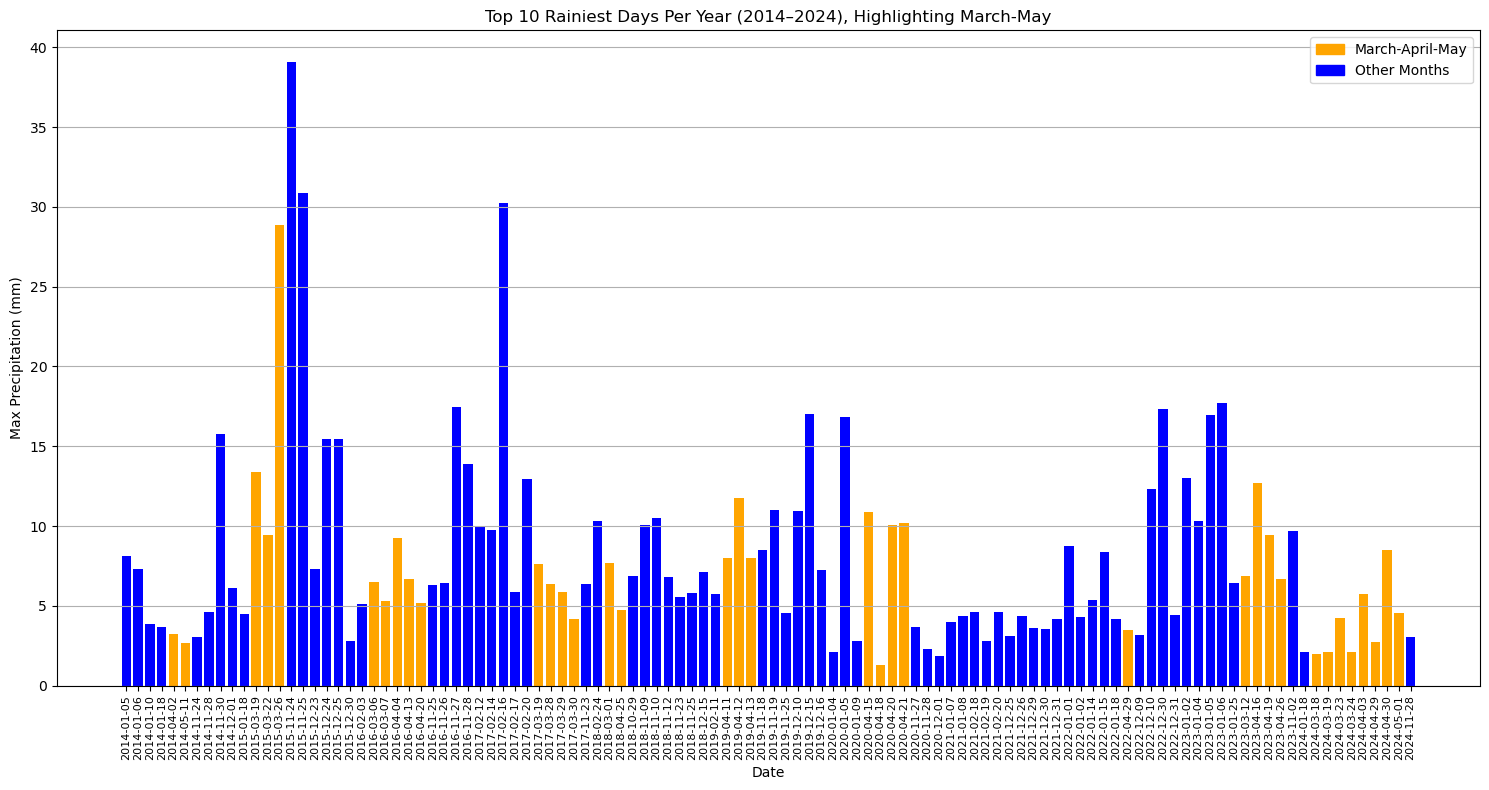

In [12]:
# Step 1: Identify the top 10 rainiest days per year (fixing the warning)
top_10_per_year = (
    daily_max_df.groupby("Year", group_keys=False)
    .apply(lambda x: x.nlargest(10, "Max Precipitation (mm)"), include_groups=False)
    .reset_index(drop=True)
)

# Step 2: Add a column to flag events in March, April, or May (MAM)
top_10_per_year["Month"] = top_10_per_year["valid_time"].dt.month
top_10_per_year["Is_MAM"] = top_10_per_year["Month"].isin([3, 4, 5])

# Step 3: Sort by date (chronologically)
top_10_per_year = top_10_per_year.sort_values(by="valid_time")

# Step 4: Plot the data
plt.figure(figsize=(15, 8))

# Ensure correct color mapping (MAM = Orange, Others = Blue)
colors = ["orange" if is_mam else "blue" for is_mam in top_10_per_year["Is_MAM"]]

plt.bar(
    top_10_per_year["valid_time"].dt.strftime("%Y-%m-%d"),
    top_10_per_year["Max Precipitation (mm)"],
    color=colors,
)

# Step 5: Customize labels and grid
plt.xticks(rotation=90, fontsize=8)
plt.title("Top 10 Rainiest Days Per Year (2014–2024), Highlighting March-May")
plt.xlabel("Date")
plt.ylabel("Max Precipitation (mm)")
plt.grid(axis="y")

# Ensure correct legend
legend_patches = [
    mpatches.Patch(color="orange", label="March-April-May"),
    mpatches.Patch(color="blue", label="Other Months"),
]
plt.legend(handles=legend_patches, loc="upper right")

# Step 6: Save and display the plot
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-4x4-march-may-rainiest-days.png"), dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# Convert xarray DataArray to Pandas DataFrame (if not already done)
daily_precipitation_mm = precipitation_mm.resample(valid_time="1D").sum()
max_daily_precipitation = daily_precipitation_mm.max(dim=["latitude", "longitude"])

# Convert to DataFrame
df_max_precip = max_daily_precipitation.to_dataframe(name="Max Precipitation (mm)").reset_index()

# Check if df_max_precip exists before computing percentiles
if "Max Precipitation (mm)" in df_max_precip.columns:
    # Compute percentiles
    percentile_999 = df_max_precip["Max Precipitation (mm)"].quantile(0.999)  # 99.9th
    percentile_99 = df_max_precip["Max Precipitation (mm)"].quantile(0.99)    # 99th
    percentile_98 = df_max_precip["Max Precipitation (mm)"].quantile(0.98)    # 98th
    percentile_95 = df_max_precip["Max Precipitation (mm)"].quantile(0.95)    # 95th

    # Print the percentile thresholds
    print(f"99.9th Percentile Threshold: {percentile_999:.2f} mm")
    print(f"99th Percentile Threshold: {percentile_99:.2f} mm")
    print(f"98th Percentile Threshold: {percentile_98:.2f} mm")
    print(f"95th Percentile Threshold: {percentile_95:.2f} mm")
else:
    print("Error: 'Max Precipitation (mm)' column not found in df_max_precip")


99.9th Percentile Threshold: 17.68 mm
99th Percentile Threshold: 7.98 mm
98th Percentile Threshold: 4.46 mm
95th Percentile Threshold: 1.67 mm


In [14]:
# Assign percentiles, ensuring each date gets only the highest label
def assign_percentile(value):
    if value >= percentile_999:
        return "99.9th"
    elif value >= percentile_99:
        return "99th"
    elif value >= percentile_98:
        return "98th"
    else:
        return None  # This avoids including lower percentiles

# Apply the function to assign a single percentile per day
df_max_precip["Percentile"] = df_max_precip["Max Precipitation (mm)"].apply(assign_percentile)

# Filter out any rows where no percentile was assigned
df_percentiles = df_max_precip.dropna(subset=["Percentile"]).sort_values(by="valid_time")

# Display the results
print(df_percentiles)

# Save results to CSV
df_percentiles.to_csv(os.path.join(output_folder, "rainiest_days_percentiles_cleaned.csv"), index=False)

print("Exported: rainiest_days_percentiles_cleaned.csv")

     valid_time  number  Max Precipitation (mm) Percentile
4    2014-01-05       0                8.142105       99th
5    2014-01-06       0                7.312131       98th
331  2014-11-28       0                4.616221       98th
333  2014-11-30       0               15.756607       99th
334  2014-12-01       0                6.152196       98th
...         ...     ...                     ...        ...
3402 2023-04-26       0                6.712597       98th
3592 2023-11-02       0                9.682542       99th
3745 2024-04-03       0                5.740723       98th
3772 2024-04-30       0                8.504062       99th
3773 2024-05-01       0                4.537688       98th

[81 rows x 4 columns]
Exported: rainiest_days_percentiles_cleaned.csv


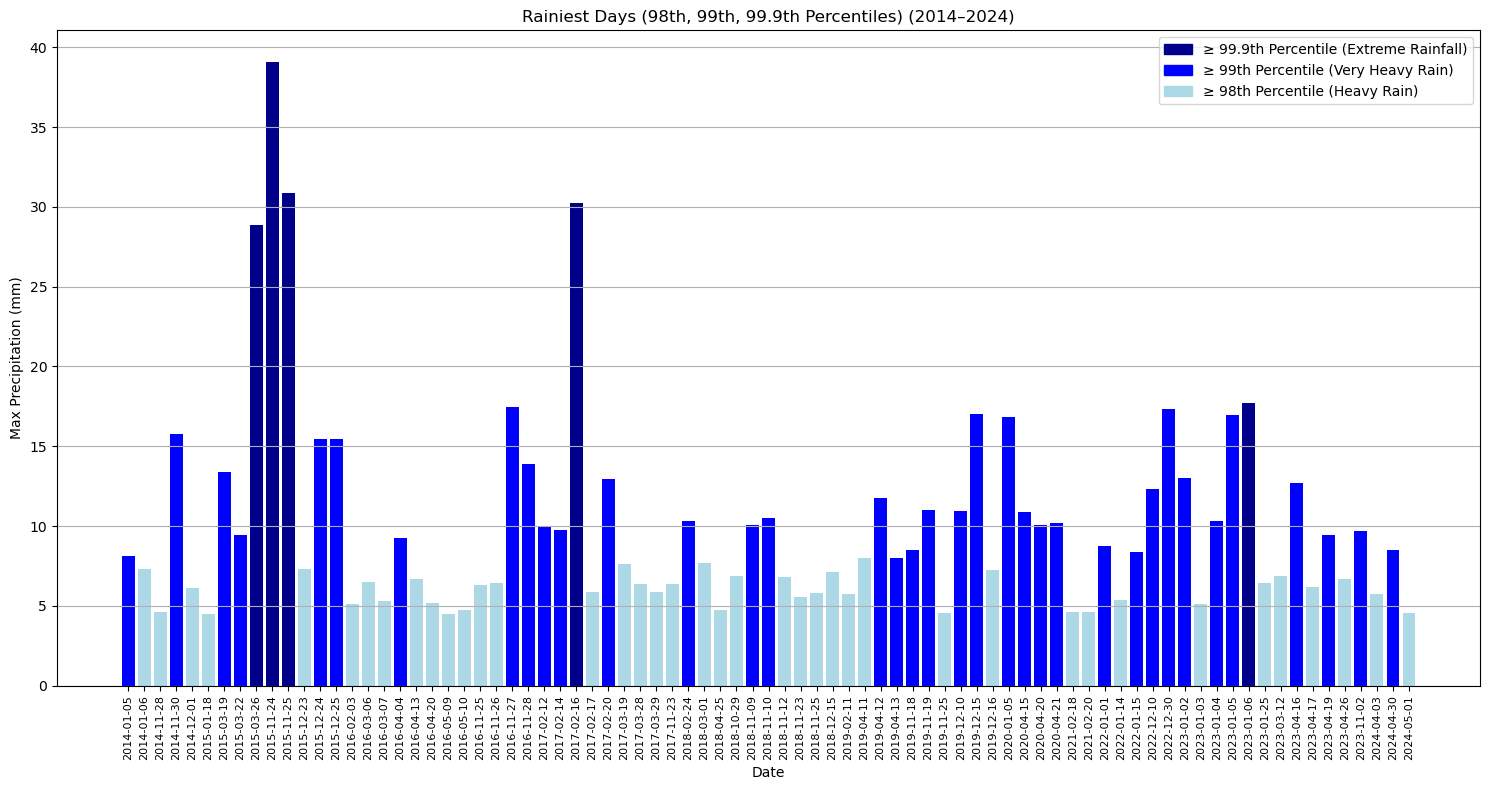

In [15]:
# Ensure max_daily_precipitation is already computed
daily_precipitation_mm = precipitation_mm.resample(valid_time="1D").sum()
max_daily_precipitation = daily_precipitation_mm.max(dim=["latitude", "longitude"])

# Convert to Pandas DataFrame
df_max_precip = max_daily_precipitation.to_dataframe(name="Max Precipitation (mm)").reset_index()

# Compute the 98th, 99th, and 99.9th percentile thresholds
percentile_999 = np.percentile(df_max_precip["Max Precipitation (mm)"], 99.9)
percentile_99 = np.percentile(df_max_precip["Max Precipitation (mm)"], 99)
percentile_98 = np.percentile(df_max_precip["Max Precipitation (mm)"], 98)

# Keep only days in the top 98th percentile and above
df_extreme_precip = df_max_precip[df_max_precip["Max Precipitation (mm)"] >= percentile_98].copy()

# Define colors based on percentile thresholds
colors = []
for precip in df_extreme_precip["Max Precipitation (mm)"]:
    if precip >= percentile_999:
        colors.append("darkblue")  # 99.9th percentile (Extreme Rainfall)
    elif precip >= percentile_99:
        colors.append("blue")  # 99th percentile (Very Heavy Rain)
    elif precip >= percentile_98:
        colors.append("lightblue")  # 98th percentile (Heavy Rain)

# Create the bar chart
plt.figure(figsize=(15, 8))
plt.bar(
    df_extreme_precip["valid_time"].dt.strftime("%Y-%m-%d"),
    df_extreme_precip["Max Precipitation (mm)"],
    color=colors
)

# Customize x-axis
plt.xticks(rotation=90, fontsize=8)
plt.title("Rainiest Days (98th, 99th, 99.9th Percentiles) (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Max Precipitation (mm)")
plt.grid(axis="y")

# Add a legend (top Right)
legend_patches = [
    Patch(color="darkblue", label="≥ 99.9th Percentile (Extreme Rainfall)"),
    Patch(color="blue", label="≥ 99th Percentile (Very Heavy Rain)"),
    Patch(color="lightblue", label="≥ 98th Percentile (Heavy Rain)")
]
plt.legend(handles=legend_patches, loc="upper right")  # Legend in bottom right

# Final adjustments
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-top-percentiles.png"), dpi=300, bbox_inches="tight")
plt.show()


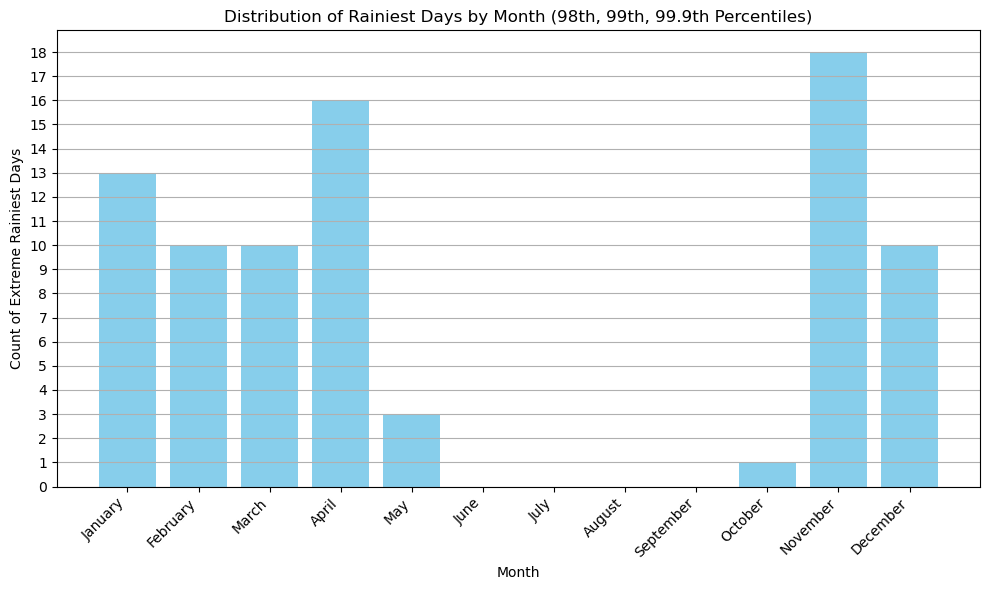

In [16]:
# Step 1: Compute the percentile thresholds
percentile_999 = df_max_precip["Max Precipitation (mm)"].quantile(0.999)  # 99.9th
percentile_99 = df_max_precip["Max Precipitation (mm)"].quantile(0.99)    # 99th
percentile_98 = df_max_precip["Max Precipitation (mm)"].quantile(0.98)    # 98th

# Step 2: Filter for rainy days in the 98th percentile and above
df_extreme_precip = df_max_precip[df_max_precip["Max Precipitation (mm)"] >= percentile_98].copy()

# Step 3: Extract the month from each rainy day's date (fixing the warning)
df_extreme_precip.loc[:, "Month"] = df_extreme_precip["valid_time"].dt.month

# Step 4: Count occurrences of rainy days per month
monthly_counts = df_extreme_precip["Month"].value_counts().sort_index()

# Step 5: Ensure all months are included (even if they have 0 counts)
all_months = list(range(1, 13))  # Months from January (1) to December (12)
monthly_counts = monthly_counts.reindex(all_months, fill_value=0)

# Step 6: Convert month numbers to month names for the x-axis
month_names = [calendar.month_name[i] for i in monthly_counts.index]

# Step 7: Plot the distribution of extreme rainy days by month
plt.figure(figsize=(10, 6))
plt.bar(month_names, monthly_counts.values, color="skyblue")

# Step 8: Ensure Y-axis only shows integers
y_max = int(monthly_counts.max())  # Get the highest count
plt.yticks(np.arange(0, y_max + 1, 1))  # Generate ticks from 0 to max count

# Step 9: Add labels and grid
plt.title("Distribution of Rainiest Days by Month (98th, 99th, 99.9th Percentiles)")
plt.xlabel("Month")
plt.ylabel("Count of Extreme Rainiest Days")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.grid(axis="y")

# Step 10: Save and display the plot
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-4x4-bar-graph-extreme-rainiest-days.png"), dpi=300, bbox_inches="tight")
plt.show()


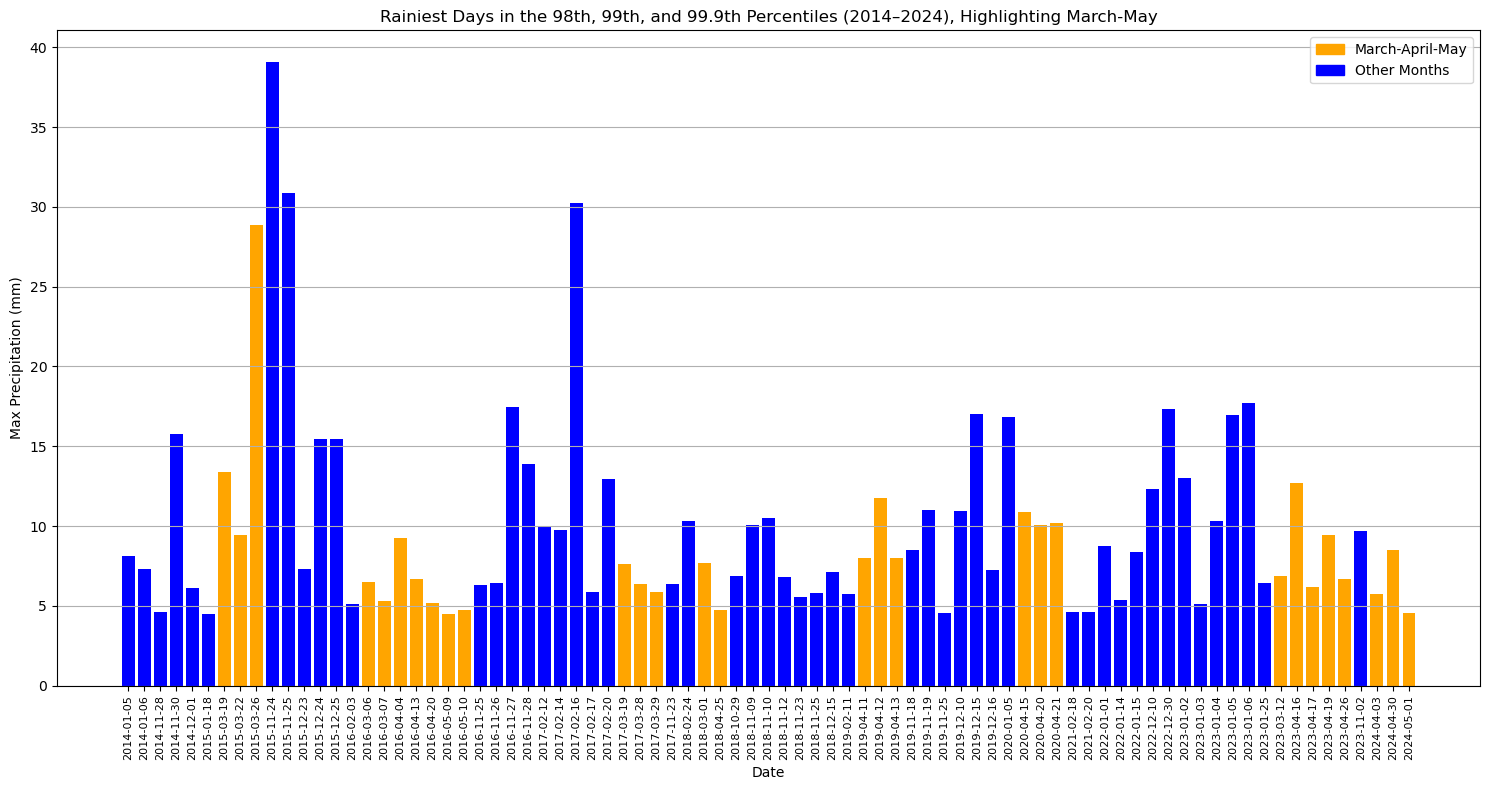

In [17]:
# Step 1: Compute the percentile thresholds
percentile_999 = df_max_precip["Max Precipitation (mm)"].quantile(0.999)  # 99.9th
percentile_99 = df_max_precip["Max Precipitation (mm)"].quantile(0.99)    # 99th
percentile_98 = df_max_precip["Max Precipitation (mm)"].quantile(0.98)    # 98th

# Step 2: Filter for rainy days in the 98th percentile and above
df_extreme_precip = df_max_precip[df_max_precip["Max Precipitation (mm)"] >= percentile_98].copy()

# Step 3: Add a column to flag events in March, April, or May (MAM)
df_extreme_precip.loc[:, "Month"] = df_extreme_precip["valid_time"].dt.month
df_extreme_precip.loc[:, "Is_MAM"] = df_extreme_precip["Month"].isin([3, 4, 5])

# Step 4: Sort by date (chronologically)
df_extreme_precip = df_extreme_precip.sort_values(by="valid_time")

# Step 5: Plot the data
plt.figure(figsize=(15, 8))

# Ensure correct color mapping (MAM = Orange, Others = Blue)
colors = ["orange" if is_mam else "blue" for is_mam in df_extreme_precip["Is_MAM"]]

plt.bar(
    df_extreme_precip["valid_time"].dt.strftime("%Y-%m-%d"),
    df_extreme_precip["Max Precipitation (mm)"],
    color=colors,
)

# Step 6: Customize labels and grid
plt.xticks(rotation=90, fontsize=8)
plt.title("Rainiest Days in the 98th, 99th, and 99.9th Percentiles (2014–2024), Highlighting March-May")
plt.xlabel("Date")
plt.ylabel("Max Precipitation (mm)")
plt.grid(axis="y")

# Step 7: Ensure correct legend
legend_patches = [
    mpatches.Patch(color="orange", label="March-April-May"),
    mpatches.Patch(color="blue", label="Other Months"),
]
plt.legend(handles=legend_patches, loc="upper right")

# Step 8: Save and display the plot
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-4x4-march-may-extreme-rainiest-days.png"), dpi=300, bbox_inches="tight")
plt.show()


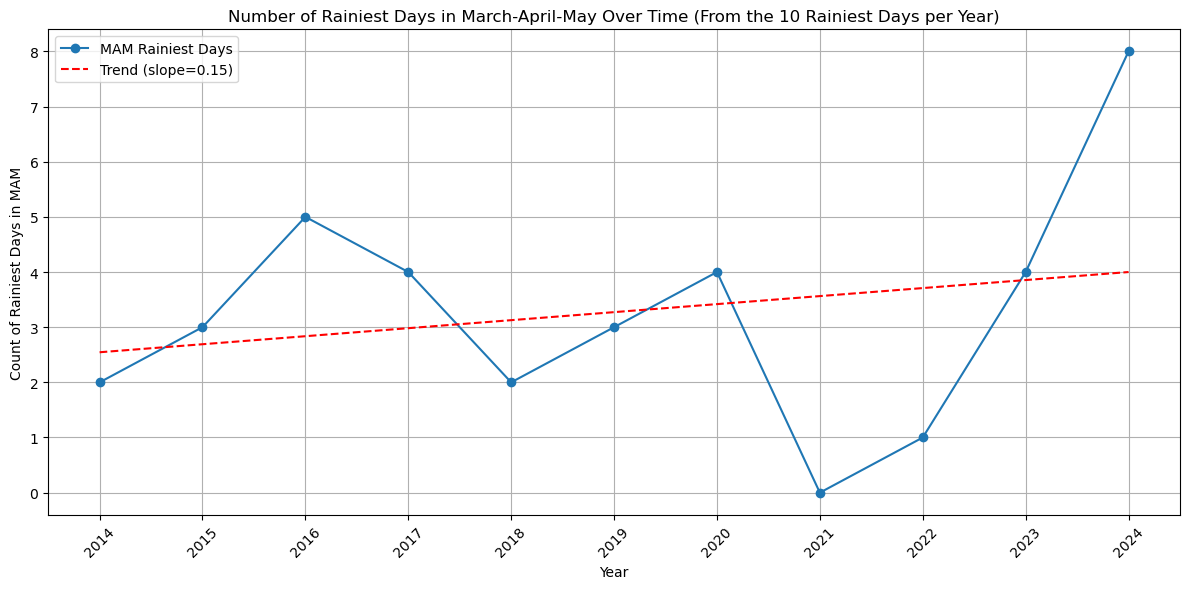

In [18]:
# Step 1: Recreate "Top 10 Rainiest Days per Year"
top_10_per_year = (
    daily_max_df.groupby("Year", group_keys=False)
    .apply(lambda x: x.nlargest(10, "Max Precipitation (mm)"), include_groups=False)
    .reset_index(drop=True)
)

# Step 2: Ensure the DataFrame has an "Is_MAM" column and extract "Year"
top_10_per_year["Month"] = top_10_per_year["valid_time"].dt.month
top_10_per_year["Year"] = top_10_per_year["valid_time"].dt.year  # FIX: Extract Year
top_10_per_year["Is_MAM"] = top_10_per_year["Month"].isin([3, 4, 5])  # March, April, May

# Step 3: Count the number of MAM rainiest days per year
mam_counts = (
    top_10_per_year[top_10_per_year["Is_MAM"]]  # Filter for MAM days
    .groupby("Year")  # FIX: Now "Year" exists
    .size()
    .reindex(range(top_10_per_year["Year"].min(), top_10_per_year["Year"].max() + 1), fill_value=0)  # Fill missing years with 0
)

# Step 4: Plot the MAM counts over time
plt.figure(figsize=(12, 6))
plt.plot(mam_counts.index, mam_counts.values, marker="o", label="MAM Rainiest Days")

# Step 5: Fit and plot a trend line
slope, intercept, _, _, _ = linregress(mam_counts.index, mam_counts.values)
trendline = slope * mam_counts.index + intercept
plt.plot(mam_counts.index, trendline, linestyle="--", color="red", label=f"Trend (slope={slope:.2f})")

# Step 6: Add labels and title
plt.title("Number of Rainiest Days in March-April-May Over Time (From the 10 Rainiest Days per Year)")
plt.xlabel("Year")
plt.ylabel("Count of Rainiest Days in MAM")
plt.xticks(mam_counts.index, rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-MAM-linear-regression.png"), dpi=300, bbox_inches="tight")
plt.show()


In [19]:
# Calculate trend significance for MAM
slope, intercept, r_value, p_value, std_err = linregress(mam_counts.index, mam_counts.values)

# Print the results
print(f"Slope of the trend: {slope:.2f} rainy days per year")
print(f"R-squared value: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The trend is statistically significant at the 5% significance level.")
else:
    print("The trend is not statistically significant.")


Slope of the trend: 0.15 rainy days per year
R-squared value: 0.05
P-value: 0.5069
The trend is not statistically significant.


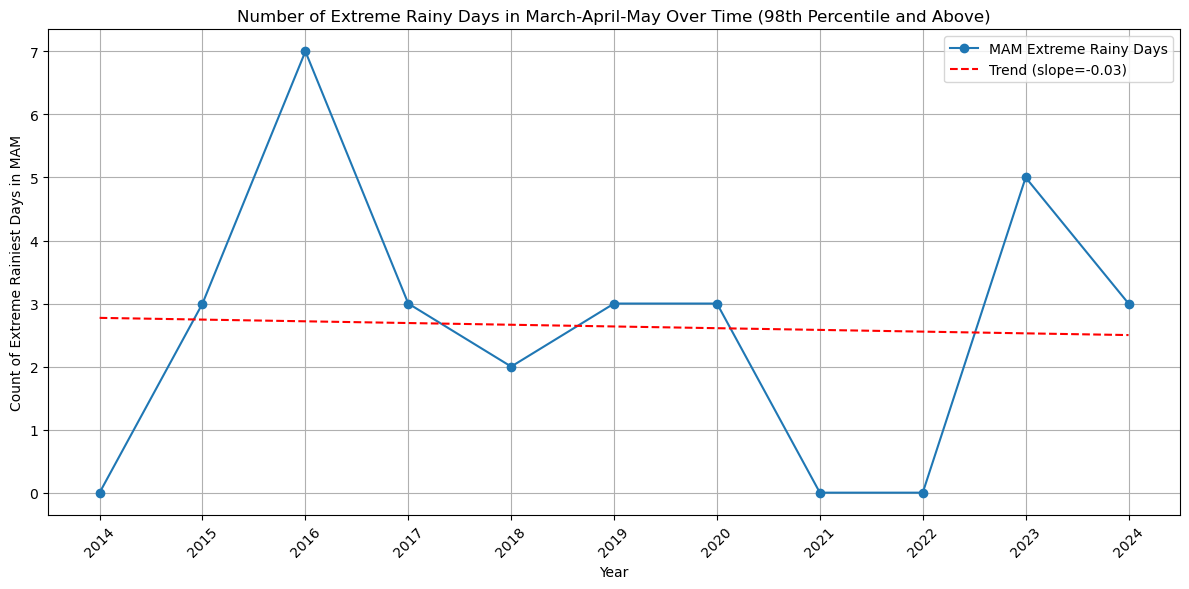

Slope of the trend: -0.03 rainy days per year
R-squared value: 0.00
P-value: 0.9026
The trend is not statistically significant.


In [20]:
# Step 1: Compute the percentile thresholds
percentile_999 = df_max_precip["Max Precipitation (mm)"].quantile(0.999)  # 99.9th
percentile_99 = df_max_precip["Max Precipitation (mm)"].quantile(0.99)    # 99th
percentile_98 = df_max_precip["Max Precipitation (mm)"].quantile(0.98)    # 98th

# Step 2: Filter for rainy days in the 98th percentile and above
df_extreme_precip = df_max_precip[df_max_precip["Max Precipitation (mm)"] >= percentile_98].copy()

# Step 3: Add a column to flag events in March, April, or May (MAM)
df_extreme_precip.loc[:, "Month"] = df_extreme_precip["valid_time"].dt.month
df_extreme_precip.loc[:, "Year"] = df_extreme_precip["valid_time"].dt.year
df_extreme_precip.loc[:, "Is_MAM"] = df_extreme_precip["Month"].isin([3, 4, 5])

# Step 4: Count the number of MAM extreme rainy days per year
mam_counts = (
    df_extreme_precip[df_extreme_precip["Is_MAM"]]  # Filter for MAM days
    .groupby("Year")
    .size()
    .reindex(range(df_extreme_precip["Year"].min(), df_extreme_precip["Year"].max() + 1), fill_value=0)  # Fill missing years with 0
)

# Step 5: Fit a trend line and compute statistical significance
slope, intercept, r_value, p_value, std_err = linregress(mam_counts.index, mam_counts.values)
trendline = slope * mam_counts.index + intercept

# Step 6: Plot the MAM counts over time
plt.figure(figsize=(12, 6))
plt.plot(mam_counts.index, mam_counts.values, marker="o", label="MAM Extreme Rainy Days")
plt.plot(mam_counts.index, trendline, linestyle="--", color="red", label=f"Trend (slope={slope:.2f})")

# Step 7: Add labels and title
plt.title("Number of Extreme Rainy Days in March-April-May Over Time (98th Percentile and Above)")
plt.xlabel("Year")
plt.ylabel("Count of Extreme Rainiest Days in MAM")
plt.xticks(mam_counts.index, rotation=45)
plt.legend()
plt.grid()

# Step 8: Save and display the plot
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precip-MAM-extreme-linear-regression.png"), dpi=300, bbox_inches="tight")
plt.show()

# Step 9: Print statistical significance results
print(f"Slope of the trend: {slope:.2f} rainy days per year")
print(f"R-squared value: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")

# Step 10: Check for statistical significance
if p_value < 0.05:
    print("The trend is statistically significant at the 5% significance level.")
else:
    print("The trend is not statistically significant.")


In [21]:
# Step 1: Load and process precipitation data
precip_ds = xr.open_dataset("Data/precip-2014-2024-full.nc")
precipitation_mm = precip_ds["tp"] * 1000  # Convert from meters to mm
daily_precipitation_mm = precipitation_mm.resample(valid_time="1D").sum()

# Step 2: Define your event dates
event_dates = [
    "2014-01-05", "2015-03-26", "2016-04-04", "2017-02-16", "2018-02-24",
    "2019-04-12", "2020-01-05", "2021-02-18", "2022-01-01", "2023-01-06", "2024-04-30"
]
event_dates = [pd.to_datetime(d) for d in event_dates]

# Step 3: Define and create output folders
output_folder = "Outputs_Precip"
geotiff_dir = os.path.join(output_folder, "geotiffs")
png_dir = os.path.join(output_folder, "pngs")
os.makedirs(geotiff_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

# Step 4: Load reference raster for spatial metadata
with rasterio.open("reference-raster.tif") as ref:
    transform = ref.transform
    crs = ref.crs

# Step 5: Export each event
for rain_date in event_dates:
    year = rain_date.year
    rain_date_str = rain_date.strftime("%Y-%m-%d")

    try:
        precip_grid = daily_precipitation_mm.sel(valid_time=rain_date)
        raster_data = precip_grid.values.squeeze()
    except KeyError:
        print(f"⚠️ No data found for {rain_date_str}")
        continue

    # Export GeoTIFF
    precip_grid.rio.write_crs(crs, inplace=True)
    precip_grid.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    precip_grid.rio.to_raster(os.path.join(geotiff_dir, f"rain_{year}_{rain_date_str}.tif"))

    # Export PNG
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        raster_data,
        cmap="Blues",
        cbar_kws={'label': 'Precipitation (mm)'},
        xticklabels=precip_grid["longitude"].values,
        yticklabels=precip_grid["latitude"].values
    )
    plt.title(f"Rain Event: {rain_date_str} ({year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(os.path.join(png_dir, f"rain_{year}_{rain_date_str}.png"), dpi=300)
    plt.close()

    print(f"✅ Exported: {rain_date_str} ({year})")

✅ Exported: 2014-01-05 (2014)
✅ Exported: 2015-03-26 (2015)
✅ Exported: 2016-04-04 (2016)
✅ Exported: 2017-02-16 (2017)
✅ Exported: 2018-02-24 (2018)
✅ Exported: 2019-04-12 (2019)
✅ Exported: 2020-01-05 (2020)
✅ Exported: 2021-02-18 (2021)
✅ Exported: 2022-01-01 (2022)
✅ Exported: 2023-01-06 (2023)
✅ Exported: 2024-04-30 (2024)
